# 10 - Immediate Enrichment Analysis

This notebook implements the immediate enrichment opportunities identified after data collection:

1. **VSM Compression Index** - Quantify organizational density across governance categories
2. **Sustainability Risk Score** - Combined health metric integrating Ostrom + VSM + Bus Factor
3. **Ostrom-Entropy Correlation Matrix** - Identify actionable governance recommendations
4. **Category Transition Analysis** - What patterns trigger Toy→Stadium→Federation transitions
5. **Fork Prediction Analysis** - Test H² (cohomological obstruction) spike hypothesis

In [1]:
import json
import sys
from pathlib import Path
from datetime import datetime, timedelta
from typing import Dict, List, Any, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Add src to path
sys.path.insert(0, '..')
from src.analysis.entropy_calculation import EntropyCalculator
from data.candidates import ALL_CANDIDATES

# Build category lookup
category_lookup = {}
for category, repos in ALL_CANDIDATES.items():
    for repo in repos:
        category_lookup[repo.lower()] = category

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['text.usetex'] = False

print("Setup complete!")

Setup complete!


## Load All Data Sources

In [2]:
# Load raw project data
data_dir = Path("../data/raw")
projects = {}

for file_path in data_dir.glob("*_data.json"):
    with open(file_path, 'r') as f:
        data = json.load(f)
        repo_info = data.get('repository', {})
        if 'error' in repo_info or 'full_name' not in repo_info:
            continue
        repo_name = repo_info['full_name']
        data['_category'] = category_lookup.get(repo_name.lower(), 'unknown')
        projects[repo_name] = data

# Load processed data
processed_dir = Path("../data/processed")
df_ostrom = pd.read_csv(processed_dir / 'ostrom_vsm_analysis.csv')
df_vsm = pd.read_csv(processed_dir / 'vsm_analysis.csv')
df_analysis = pd.read_csv(processed_dir / 'analysis_results.csv')

print(f"Loaded {len(projects)} projects")
print(f"Ostrom analysis: {len(df_ostrom)} records")
print(f"VSM analysis: {len(df_vsm)} records")
print(f"Analysis results: {len(df_analysis)} records")

Loaded 94 projects
Ostrom analysis: 94 records
VSM analysis: 94 records
Analysis results: 93 records


---
## 1. VSM Compression Index

The **VSM Compression Index** quantifies how "compressed" or "dense" the organizational structure is.

**Concept**: In Viable System Model terms, a healthy organization has balanced subsystems (S1-S5). 
- **High compression** = few subsystems active, functions collapsed into fewer roles
- **Low compression** = distributed functions across multiple subsystems

**Formula**: `VSM_CI = 1 - (Variance of S1-S5 scores / Max possible variance)`

In [3]:
def calculate_vsm_compression_index(project_data: dict) -> dict:
    """
    Calculate VSM Compression Index for a project.
    
    Returns:
        dict with compression_index (0-1), balance_score, dominant_subsystem
    """
    # Extract VSM subsystem indicators
    contributors = project_data.get('contributors', [])
    maintainers = project_data.get('maintainers', {}).get('statistics', {})
    commits = project_data.get('recent_commits', [])
    gov_files = project_data.get('governance_files', {})
    repo = project_data.get('repository', {})
    issues = project_data.get('issues', {}).get('statistics', {})
    prs = project_data.get('pull_requests', {}).get('statistics', {})
    
    # S1: Operations (actual work being done)
    s1_commits = min(100, len(commits) * 2)  # Normalize to 0-100
    s1_contributors = min(100, len(contributors) * 2)
    s1 = (s1_commits + s1_contributors) / 2
    
    # S2: Coordination (anti-oscillation)
    has_codeowners = 50 if gov_files.get('.github/CODEOWNERS') else 0
    review_time_score = 50 if prs.get('avg_time_to_merge', 0) > 0 else 0
    s2 = has_codeowners + review_time_score
    
    # S3: Control (internal regulation)
    active_maintainers = maintainers.get('active_maintainers_6mo', 0)
    s3_maintainers = min(50, active_maintainers * 10)
    s3_monitoring = 50 if gov_files.get('CONTRIBUTING.md') else 0
    s3 = s3_maintainers + s3_monitoring
    
    # S4: Intelligence (environment scanning)
    has_discussions = 30 if repo.get('has_discussions') else 0
    has_roadmap = 30 if gov_files.get('ROADMAP.md') else 0
    issue_responsiveness = min(40, 40 * (1 - min(1, issues.get('avg_time_to_close', 720) / 720)))
    s4 = has_discussions + has_roadmap + issue_responsiveness
    
    # S5: Policy (identity/purpose)
    has_governance = 40 if gov_files.get('GOVERNANCE.md') else 0
    has_license = 30 if repo.get('license') else 0
    has_coc = 30 if gov_files.get('CODE_OF_CONDUCT.md') else 0
    s5 = has_governance + has_license + has_coc
    
    scores = [s1, s2, s3, s4, s5]
    labels = ['S1_Operations', 'S2_Coordination', 'S3_Control', 'S4_Intelligence', 'S5_Policy']
    
    # Calculate compression metrics
    mean_score = np.mean(scores)
    variance = np.var(scores)
    max_variance = 2500  # Max possible variance when one is 100, others are 0
    
    # Compression Index: Low variance = high compression (functions consolidated)
    compression_index = 1 - (variance / max_variance)
    
    # Balance Score: How evenly distributed (using coefficient of variation inverse)
    cv = np.std(scores) / mean_score if mean_score > 0 else 1
    balance_score = 1 / (1 + cv)  # Higher = more balanced
    
    # Dominant subsystem
    dominant_idx = np.argmax(scores)
    dominant_subsystem = labels[dominant_idx]
    
    return {
        'compression_index': compression_index,
        'balance_score': balance_score,
        'mean_score': mean_score,
        'variance': variance,
        'dominant_subsystem': dominant_subsystem,
        'S1_Operations': s1,
        'S2_Coordination': s2,
        'S3_Control': s3,
        'S4_Intelligence': s4,
        'S5_Policy': s5,
    }

# Calculate for all projects
vsm_compression_data = []
for repo_name, data in projects.items():
    result = calculate_vsm_compression_index(data)
    result['repository'] = repo_name
    result['category'] = data.get('_category', 'unknown')
    vsm_compression_data.append(result)

df_compression = pd.DataFrame(vsm_compression_data)

print("\n" + "="*70)
print("VSM COMPRESSION INDEX ANALYSIS")
print("="*70)
print("\nCompression Index by Category (higher = more consolidated/compressed):")
print(df_compression.groupby('category')[['compression_index', 'balance_score', 'mean_score']].mean().round(3))


VSM COMPRESSION INDEX ANALYSIS

Compression Index by Category (higher = more consolidated/compressed):
            compression_index  balance_score  mean_score
category                                                
club                    0.714          0.691      60.378
federation              0.729          0.720      63.481
stadium                 0.718          0.632      46.334
toy                     0.826          0.557      27.163
unknown                 0.576          0.653      60.000


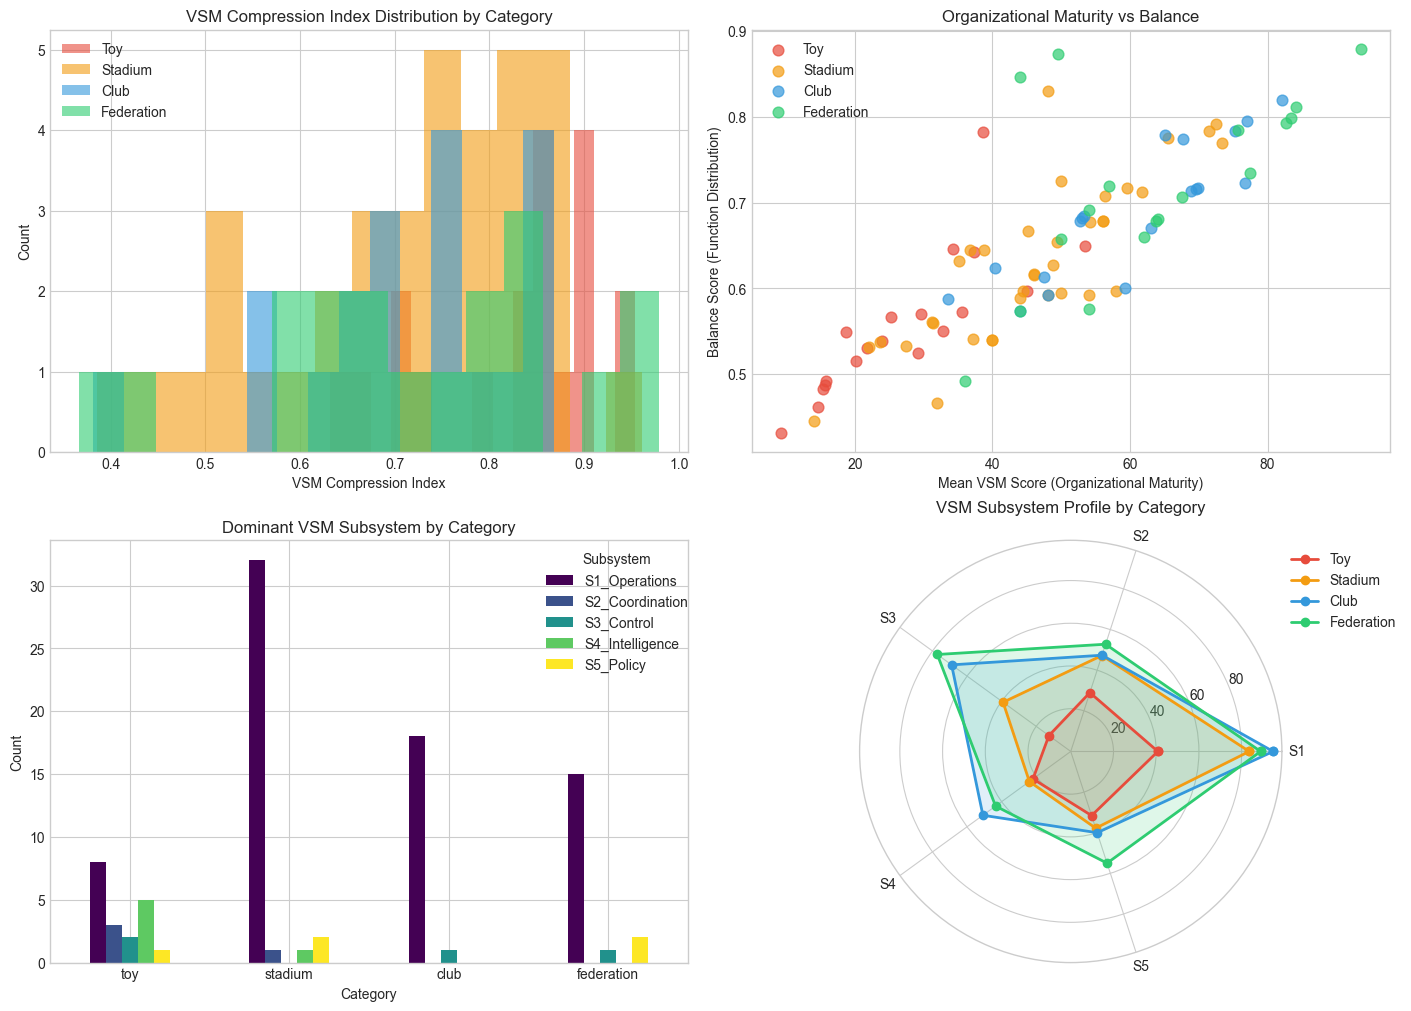


Figure saved to docs/diagrams/vsm_compression_analysis.png


In [4]:
# Visualize VSM Compression
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

category_order = ['toy', 'stadium', 'club', 'federation']
colors = {'toy': '#e74c3c', 'stadium': '#f39c12', 'club': '#3498db', 'federation': '#2ecc71', 'unknown': 'gray'}

# 1. Compression Index Distribution
ax = axes[0, 0]
for cat in category_order:
    if cat in df_compression['category'].values:
        data = df_compression[df_compression['category'] == cat]['compression_index']
        ax.hist(data, alpha=0.6, label=cat.title(), color=colors.get(cat), bins=15)
ax.set_xlabel('VSM Compression Index')
ax.set_ylabel('Count')
ax.set_title('VSM Compression Index Distribution by Category')
ax.legend()

# 2. Balance Score vs Mean Score
ax = axes[0, 1]
for cat in category_order:
    if cat in df_compression['category'].values:
        subset = df_compression[df_compression['category'] == cat]
        ax.scatter(subset['mean_score'], subset['balance_score'], 
                   label=cat.title(), color=colors.get(cat), alpha=0.7, s=60)
ax.set_xlabel('Mean VSM Score (Organizational Maturity)')
ax.set_ylabel('Balance Score (Function Distribution)')
ax.set_title('Organizational Maturity vs Balance')
ax.legend()

# 3. Dominant Subsystem by Category
ax = axes[1, 0]
dominant_counts = df_compression.groupby(['category', 'dominant_subsystem']).size().unstack(fill_value=0)
dominant_counts = dominant_counts.reindex(category_order, fill_value=0)
dominant_counts.plot(kind='bar', ax=ax, colormap='viridis')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Dominant VSM Subsystem by Category')
ax.legend(title='Subsystem', bbox_to_anchor=(1.02, 1))
ax.tick_params(axis='x', rotation=0)

# 4. Subsystem Radar by Category
ax = axes[1, 1]
ax.remove()
ax = fig.add_subplot(2, 2, 4, polar=True)

subsystem_cols = ['S1_Operations', 'S2_Coordination', 'S3_Control', 'S4_Intelligence', 'S5_Policy']
category_means = df_compression.groupby('category')[subsystem_cols].mean()

angles = np.linspace(0, 2 * np.pi, len(subsystem_cols), endpoint=False).tolist()
angles += angles[:1]

for cat in category_order:
    if cat in category_means.index:
        values = category_means.loc[cat].values.tolist()
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=cat.title(), color=colors.get(cat))
        ax.fill(angles, values, alpha=0.15, color=colors.get(cat))

ax.set_xticks(angles[:-1])
ax.set_xticklabels(['S1', 'S2', 'S3', 'S4', 'S5'], size=10)
ax.set_title('VSM Subsystem Profile by Category', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.savefig('../docs/diagrams/vsm_compression_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to docs/diagrams/vsm_compression_analysis.png")

In [5]:
# Key Findings for VSM Compression
print("\n" + "="*70)
print("VSM COMPRESSION INDEX - KEY FINDINGS")
print("="*70)

# Statistical test
categories_present = [c for c in category_order if c in df_compression['category'].values]
groups = [df_compression[df_compression['category'] == cat]['compression_index'].values 
          for cat in categories_present]

if len(groups) >= 2:
    stat, p_value = stats.kruskal(*groups)
    print(f"\nKruskal-Wallis test for Compression Index: H={stat:.2f}, p={p_value:.4f}")
    if p_value < 0.05:
        print("=> Significant difference between categories")

# Interpretation
toy_ci = df_compression[df_compression['category'] == 'toy']['compression_index'].mean()
fed_ci = df_compression[df_compression['category'] == 'federation']['compression_index'].mean()

print(f"\n- Toy projects: CI = {toy_ci:.3f} (higher = more compressed/single-function)")
print(f"- Federation projects: CI = {fed_ci:.3f} (lower = more distributed functions)")
print(f"\nInterpretation:")
print(f"  Federation projects have more differentiated organizational functions,")
print(f"  while Toy projects collapse most functions into a single role (the maintainer).")


VSM COMPRESSION INDEX - KEY FINDINGS

Kruskal-Wallis test for Compression Index: H=10.84, p=0.0126
=> Significant difference between categories

- Toy projects: CI = 0.826 (higher = more compressed/single-function)
- Federation projects: CI = 0.729 (lower = more distributed functions)

Interpretation:
  Federation projects have more differentiated organizational functions,
  while Toy projects collapse most functions into a single role (the maintainer).


---
## 2. Sustainability Risk Score

A **composite health metric** integrating:
- Ostrom governance scores (institutional health)
- VSM balance scores (organizational structure)
- Bus factor (key person dependency)
- Activity metrics (project vitality)

**Formula**: Weighted combination with risk flags for critical thresholds.

In [6]:
def calculate_sustainability_risk_score(repo_name: str, 
                                         project_data: dict,
                                         ostrom_row: pd.Series,
                                         compression_row: pd.Series) -> dict:
    """
    Calculate comprehensive Sustainability Risk Score.
    
    Risk score: 0-100 (higher = MORE risk, LESS sustainable)
    """
    contributors = project_data.get('contributors', [])
    maintainers = project_data.get('maintainers', {}).get('statistics', {})
    commits = project_data.get('recent_commits', [])
    repo = project_data.get('repository', {})
    
    # Component 1: Bus Factor Risk (0-100)
    if contributors:
        contributions = sorted([c.get('contributions', 0) for c in contributors], reverse=True)
        total = sum(contributions)
        cumsum = 0
        bus_factor = 0
        for c in contributions:
            cumsum += c
            bus_factor += 1
            if cumsum >= total * 0.5:
                break
    else:
        bus_factor = 1
    
    # Bus factor risk (1 = 100 risk, 5+ = 0 risk)
    bus_factor_risk = max(0, 100 - (bus_factor - 1) * 25)
    
    # Component 2: Maintainer Risk (0-100)
    active_maintainers = maintainers.get('active_maintainers_6mo', 0)
    maintainer_risk = max(0, 100 - active_maintainers * 25)
    
    # Component 3: Governance Risk (inverted Ostrom score)
    ostrom_score = ostrom_row.get('overall_score', 50) if isinstance(ostrom_row, dict) else ostrom_row['overall_score']
    governance_risk = 100 - ostrom_score
    
    # Component 4: Organizational Risk (inverted balance)
    balance_score = compression_row.get('balance_score', 0.5) if isinstance(compression_row, dict) else compression_row['balance_score']
    org_risk = (1 - balance_score) * 100
    
    # Component 5: Activity Risk
    commit_count = len(commits)
    activity_risk = max(0, 100 - commit_count * 2)  # <50 commits = some risk
    
    # Weighted composite
    risk_score = (
        bus_factor_risk * 0.30 +      # 30% weight
        maintainer_risk * 0.25 +       # 25% weight
        governance_risk * 0.20 +       # 20% weight
        org_risk * 0.15 +              # 15% weight
        activity_risk * 0.10           # 10% weight
    )
    
    # Risk flags
    flags = []
    if bus_factor <= 1:
        flags.append('CRITICAL_BUS_FACTOR')
    if active_maintainers <= 1:
        flags.append('SINGLE_MAINTAINER')
    if ostrom_score < 30:
        flags.append('WEAK_GOVERNANCE')
    if commit_count < 10:
        flags.append('LOW_ACTIVITY')
    
    # Risk level
    if risk_score >= 70 or 'CRITICAL_BUS_FACTOR' in flags:
        risk_level = 'CRITICAL'
    elif risk_score >= 50:
        risk_level = 'HIGH'
    elif risk_score >= 30:
        risk_level = 'MEDIUM'
    else:
        risk_level = 'LOW'
    
    return {
        'repository': repo_name,
        'risk_score': risk_score,
        'risk_level': risk_level,
        'bus_factor': bus_factor,
        'bus_factor_risk': bus_factor_risk,
        'maintainer_risk': maintainer_risk,
        'governance_risk': governance_risk,
        'org_risk': org_risk,
        'activity_risk': activity_risk,
        'active_maintainers': active_maintainers,
        'flags': flags,
        'flag_count': len(flags),
    }

# Build risk dashboard
risk_data = []
for repo_name, data in projects.items():
    # Get corresponding rows
    ostrom_match = df_ostrom[df_ostrom['repository'] == repo_name]
    compression_match = df_compression[df_compression['repository'] == repo_name]
    
    if len(ostrom_match) > 0 and len(compression_match) > 0:
        risk = calculate_sustainability_risk_score(
            repo_name, data,
            ostrom_match.iloc[0],
            compression_match.iloc[0]
        )
        risk['category'] = data.get('_category', 'unknown')
        risk_data.append(risk)

df_risk = pd.DataFrame(risk_data)

print("\n" + "="*70)
print("SUSTAINABILITY RISK DASHBOARD")
print("="*70)
print("\nRisk Distribution by Category:")
print(df_risk.groupby('category')[['risk_score', 'bus_factor', 'flag_count']].agg(['mean', 'std']).round(2))


SUSTAINABILITY RISK DASHBOARD

Risk Distribution by Category:
           risk_score        bus_factor       flag_count      
                 mean    std       mean   std       mean   std
category                                                      
club            35.39  17.03       3.53  2.32       0.68  0.89
federation      23.59  13.82       9.39  5.15       0.67  0.91
stadium         58.83  18.06       2.17  1.42       1.81  1.19
toy             79.12  12.47       1.47  1.02       3.16  1.01
unknown         28.89  18.70       6.00  5.66       0.50  0.71


In [7]:
# Risk Level Summary
print("\n" + "="*70)
print("RISK LEVEL SUMMARY")
print("="*70)

risk_summary = df_risk.groupby(['category', 'risk_level']).size().unstack(fill_value=0)
# Ensure proper column order
risk_cols = ['LOW', 'MEDIUM', 'HIGH', 'CRITICAL']
for col in risk_cols:
    if col not in risk_summary.columns:
        risk_summary[col] = 0
risk_summary = risk_summary[risk_cols]
print(risk_summary)

# Most at-risk projects
print("\n" + "-"*70)
print("TOP 10 HIGHEST RISK PROJECTS:")
print("-"*70)
top_risk = df_risk.nlargest(10, 'risk_score')[['repository', 'category', 'risk_score', 'risk_level', 'flags']]
for _, row in top_risk.iterrows():
    flags_str = ', '.join(row['flags']) if row['flags'] else 'None'
    print(f"  {row['repository']:40} [{row['category']:10}] Risk: {row['risk_score']:.1f} ({row['risk_level']})")
    print(f"    Flags: {flags_str}")


RISK LEVEL SUMMARY
risk_level  LOW  MEDIUM  HIGH  CRITICAL
category                               
club          9       4     1         5
federation   14       2     1         1
stadium       2       7    10        17
toy           0       0     2        17
unknown       1       1     0         0

----------------------------------------------------------------------
TOP 10 HIGHEST RISK PROJECTS:
----------------------------------------------------------------------
  sqlite/sqlite                            [stadium   ] Risk: 92.1 (CRITICAL)
    Flags: CRITICAL_BUS_FACTOR, SINGLE_MAINTAINER, WEAK_GOVERNANCE, LOW_ACTIVITY
  lukeed/kleur                             [toy       ] Risk: 91.4 (CRITICAL)
    Flags: CRITICAL_BUS_FACTOR, SINGLE_MAINTAINER, WEAK_GOVERNANCE, LOW_ACTIVITY
  jonschlinkert/is-number                  [toy       ] Risk: 91.1 (CRITICAL)
    Flags: CRITICAL_BUS_FACTOR, SINGLE_MAINTAINER, WEAK_GOVERNANCE, LOW_ACTIVITY
  feross/safe-buffer                       [toy   

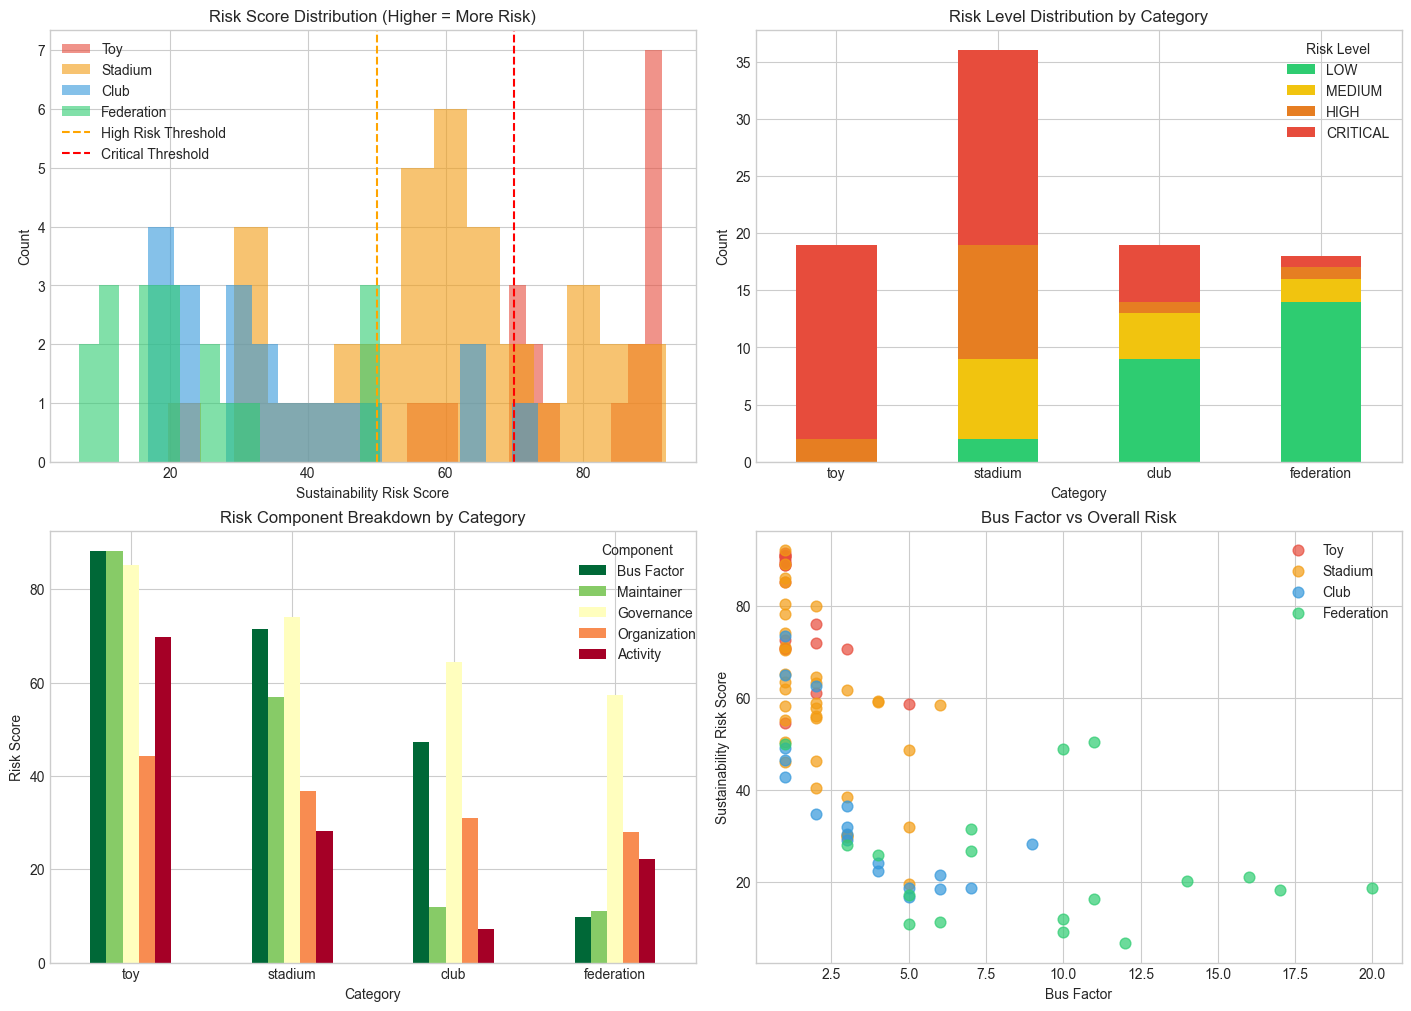


Figure saved to docs/diagrams/sustainability_risk_dashboard.png


In [8]:
# Visualize Risk Dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

# 1. Risk Score Distribution
ax = axes[0, 0]
for cat in category_order:
    if cat in df_risk['category'].values:
        data = df_risk[df_risk['category'] == cat]['risk_score']
        ax.hist(data, alpha=0.6, label=cat.title(), color=colors.get(cat), bins=15)
ax.axvline(x=50, color='orange', linestyle='--', label='High Risk Threshold')
ax.axvline(x=70, color='red', linestyle='--', label='Critical Threshold')
ax.set_xlabel('Sustainability Risk Score')
ax.set_ylabel('Count')
ax.set_title('Risk Score Distribution (Higher = More Risk)')
ax.legend()

# 2. Risk Level by Category
ax = axes[0, 1]
risk_summary_plot = risk_summary.reindex(category_order, fill_value=0)
risk_colors = {'LOW': '#2ecc71', 'MEDIUM': '#f1c40f', 'HIGH': '#e67e22', 'CRITICAL': '#e74c3c'}
risk_summary_plot.plot(kind='bar', ax=ax, color=[risk_colors[c] for c in risk_cols], stacked=True)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Risk Level Distribution by Category')
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Risk Level')

# 3. Risk Components
ax = axes[1, 0]
component_cols = ['bus_factor_risk', 'maintainer_risk', 'governance_risk', 'org_risk', 'activity_risk']
component_names = ['Bus Factor', 'Maintainer', 'Governance', 'Organization', 'Activity']
category_components = df_risk.groupby('category')[component_cols].mean()
category_components = category_components.reindex(category_order, fill_value=0)
category_components.columns = component_names
category_components.plot(kind='bar', ax=ax, colormap='RdYlGn_r')
ax.set_xlabel('Category')
ax.set_ylabel('Risk Score')
ax.set_title('Risk Component Breakdown by Category')
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Component', bbox_to_anchor=(1.02, 1))

# 4. Bus Factor vs Risk Score
ax = axes[1, 1]
for cat in category_order:
    if cat in df_risk['category'].values:
        subset = df_risk[df_risk['category'] == cat]
        ax.scatter(subset['bus_factor'], subset['risk_score'], 
                   label=cat.title(), color=colors.get(cat), alpha=0.7, s=60)
ax.set_xlabel('Bus Factor')
ax.set_ylabel('Sustainability Risk Score')
ax.set_title('Bus Factor vs Overall Risk')
ax.legend()

plt.savefig('../docs/diagrams/sustainability_risk_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to docs/diagrams/sustainability_risk_dashboard.png")

---
## 3. Ostrom-Entropy Correlation Matrix

Explore correlations between:
- Shannon entropy (contribution distribution)
- Gini coefficient (inequality)
- Each of Ostrom's 8 principles

**Goal**: Identify which governance practices most strongly correlate with healthier contribution patterns.

In [9]:
# Calculate entropy metrics for each project
entropy_calc = EntropyCalculator()

entropy_data = []
for repo_name, data in projects.items():
    contributors = data.get('contributors', [])
    if contributors:
        # Use the contributor_entropy method which handles the conversion properly
        shannon, norm_entropy = entropy_calc.contributor_entropy(contributors)
        
        # Calculate Gini separately
        contributions = [c.get('contributions', 0) for c in contributors]
        gini = entropy_calc.gini_coefficient(contributions)
        
        entropy_data.append({
            'repository': repo_name,
            'shannon_entropy': shannon,
            'normalized_entropy': norm_entropy,
            'gini_coefficient': gini,
            'contributor_count': len(contributions),
        })

df_entropy = pd.DataFrame(entropy_data)

# Merge with Ostrom data
df_corr_analysis = df_ostrom.merge(df_entropy, on='repository')

print(f"Projects with entropy+Ostrom data: {len(df_corr_analysis)}")

Projects with entropy+Ostrom data: 93


In [10]:
# Build correlation matrix
principle_cols = [f'P{i}_score' for i in range(1, 9)]
entropy_cols = ['shannon_entropy', 'normalized_entropy', 'gini_coefficient']
all_cols = principle_cols + entropy_cols + ['overall_score', 'sustainability_score']

# Only include columns that exist
available_cols = [c for c in all_cols if c in df_corr_analysis.columns]

correlation_matrix = df_corr_analysis[available_cols].corr(method='spearman')

print("\n" + "="*70)
print("OSTROM-ENTROPY CORRELATION MATRIX")
print("="*70)

# Show correlations with entropy metrics
print("\nCorrelations with Shannon Entropy:")
if 'shannon_entropy' in correlation_matrix.columns:
    entropy_corr = correlation_matrix['shannon_entropy'].drop(entropy_cols, errors='ignore').sort_values(ascending=False)
    for idx, val in entropy_corr.items():
        sig = '***' if abs(val) > 0.5 else ('**' if abs(val) > 0.3 else ('*' if abs(val) > 0.2 else ''))
        print(f"  {idx:20}: {val:+.3f} {sig}")

print("\nCorrelations with Gini Coefficient:")
if 'gini_coefficient' in correlation_matrix.columns:
    gini_corr = correlation_matrix['gini_coefficient'].drop(entropy_cols, errors='ignore').sort_values(ascending=False)
    for idx, val in gini_corr.items():
        sig = '***' if abs(val) > 0.5 else ('**' if abs(val) > 0.3 else ('*' if abs(val) > 0.2 else ''))
        print(f"  {idx:20}: {val:+.3f} {sig}")


OSTROM-ENTROPY CORRELATION MATRIX

Correlations with Shannon Entropy:
  P2_score            : +0.710 ***
  P8_score            : +0.658 ***
  sustainability_score: +0.628 ***
  overall_score       : +0.578 ***
  P6_score            : +0.401 **
  P1_score            : +0.348 **
  P5_score            : +0.339 **
  P3_score            : +0.310 **
  P4_score            : +0.271 *
  P7_score            : +0.021 

Correlations with Gini Coefficient:
  P3_score            : +0.245 *
  P6_score            : +0.130 
  P4_score            : +0.078 
  overall_score       : -0.054 
  P7_score            : -0.070 
  P1_score            : -0.108 
  P8_score            : -0.118 
  sustainability_score: -0.124 
  P5_score            : -0.154 
  P2_score            : -0.360 **


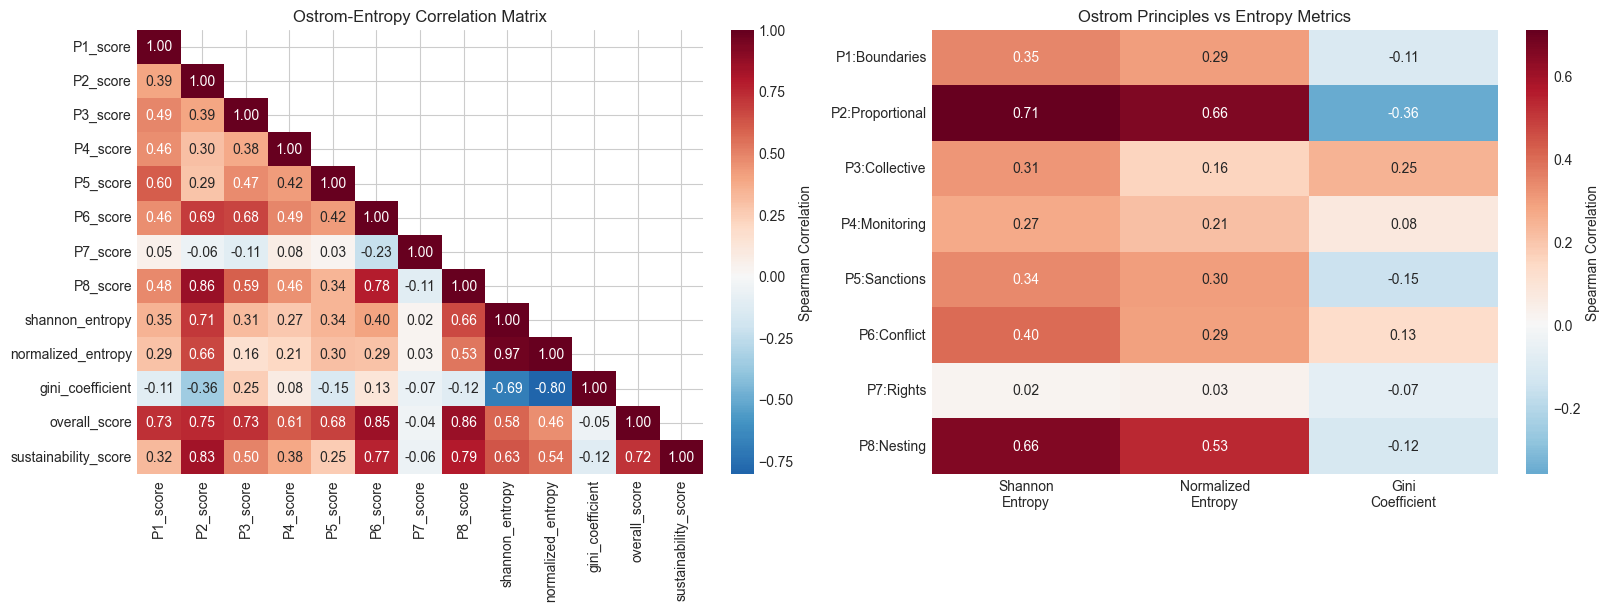


Figure saved to docs/diagrams/ostrom_entropy_correlation.png


In [11]:
# Visualize Correlation Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# 1. Full correlation heatmap
ax = axes[0]
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, ax=ax, 
            cbar_kws={'label': 'Spearman Correlation'})
ax.set_title('Ostrom-Entropy Correlation Matrix')

# 2. Focus on Entropy correlations
ax = axes[1]
entropy_focus = correlation_matrix.loc[principle_cols, entropy_cols]
sns.heatmap(entropy_focus, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax,
            cbar_kws={'label': 'Spearman Correlation'})
principle_labels = ['P1:Boundaries', 'P2:Proportional', 'P3:Collective', 'P4:Monitoring',
                    'P5:Sanctions', 'P6:Conflict', 'P7:Rights', 'P8:Nesting']
ax.set_yticklabels(principle_labels, rotation=0)
ax.set_xticklabels(['Shannon\nEntropy', 'Normalized\nEntropy', 'Gini\nCoefficient'], rotation=0)
ax.set_title('Ostrom Principles vs Entropy Metrics')

plt.savefig('../docs/diagrams/ostrom_entropy_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to docs/diagrams/ostrom_entropy_correlation.png")

In [12]:
# Key Findings and Actionable Recommendations
print("\n" + "="*70)
print("OSTROM-ENTROPY CORRELATION - KEY FINDINGS")
print("="*70)

# Find strongest correlations
if 'shannon_entropy' in correlation_matrix.columns:
    entropy_corr = correlation_matrix['shannon_entropy'].drop(entropy_cols, errors='ignore')
    strongest_positive = entropy_corr.idxmax()
    strongest_negative = entropy_corr.idxmin()
    
    print(f"\n1. STRONGEST POSITIVE correlation with Shannon Entropy:")
    print(f"   {strongest_positive}: r = {entropy_corr[strongest_positive]:.3f}")
    print(f"   => Higher {strongest_positive.replace('_score', '')} scores correlate with more distributed contributions")
    
    print(f"\n2. STRONGEST NEGATIVE correlation with Shannon Entropy:")
    print(f"   {strongest_negative}: r = {entropy_corr[strongest_negative]:.3f}")

if 'gini_coefficient' in correlation_matrix.columns:
    gini_corr = correlation_matrix['gini_coefficient'].drop(entropy_cols, errors='ignore')
    strongest_negative_gini = gini_corr.idxmin()
    
    print(f"\n3. STRONGEST correlation with LOWER inequality (Gini):")
    print(f"   {strongest_negative_gini}: r = {gini_corr[strongest_negative_gini]:.3f}")
    print(f"   => Better {strongest_negative_gini.replace('_score', '')} scores correlate with more equal contributions")

print("\n" + "-"*70)
print("ACTIONABLE RECOMMENDATIONS:")
print("-"*70)
print("""
Based on correlations, to improve contribution distribution:

1. Strengthen P2 (Proportional Equivalence):
   - Recognize all contributors (CONTRIBUTORS.md)
   - Fair review and commit rights policies
   - Mentorship programs for new contributors

2. Strengthen P8 (Nested Enterprises):
   - Create specialized working groups
   - Define clear domain ownership (CODEOWNERS)
   - Enable distributed leadership

3. Strengthen P3 (Collective Choice):
   - Document decision-making processes
   - Enable community discussions
   - RFC/proposal mechanisms
""")


OSTROM-ENTROPY CORRELATION - KEY FINDINGS

1. STRONGEST POSITIVE correlation with Shannon Entropy:
   P2_score: r = 0.710
   => Higher P2 scores correlate with more distributed contributions

2. STRONGEST NEGATIVE correlation with Shannon Entropy:
   P7_score: r = 0.021

3. STRONGEST correlation with LOWER inequality (Gini):
   P2_score: r = -0.360
   => Better P2 scores correlate with more equal contributions

----------------------------------------------------------------------
ACTIONABLE RECOMMENDATIONS:
----------------------------------------------------------------------

Based on correlations, to improve contribution distribution:

1. Strengthen P2 (Proportional Equivalence):
   - Recognize all contributors (CONTRIBUTORS.md)
   - Fair review and commit rights policies
   - Mentorship programs for new contributors

2. Strengthen P8 (Nested Enterprises):
   - Create specialized working groups
   - Define clear domain ownership (CODEOWNERS)
   - Enable distributed leadership

3. 

---
## 4. Category Transition Analysis

Analyze what patterns differentiate projects at category boundaries.

**Questions**:
- What distinguishes a Stadium project from becoming a Club?
- What enables a Club to become a Federation?
- What causes a Toy to grow into a Stadium?

In [13]:
# Combine all metrics
df_full = df_corr_analysis.merge(df_compression[['repository', 'compression_index', 'balance_score']], on='repository')
df_full = df_full.merge(df_risk[['repository', 'risk_score', 'bus_factor']], on='repository')

print(f"Combined dataset: {len(df_full)} projects")

# Feature columns for analysis - only include columns that exist
principle_cols = [f'P{i}_score' for i in range(1, 9)]
potential_feature_cols = principle_cols + ['normalized_entropy', 'gini_coefficient', 
                                            'compression_index', 'balance_score', 'bus_factor']
feature_cols = [c for c in potential_feature_cols if c in df_full.columns]

# Category statistics
print("\n" + "="*70)
print("CATEGORY TRANSITION ANALYSIS")
print("="*70)

print("\nMean values by category:")
category_stats = df_full.groupby('category')[feature_cols].mean()
category_stats = category_stats.reindex(category_order, fill_value=0)
print(category_stats.T.round(2))

Combined dataset: 93 projects

CATEGORY TRANSITION ANALYSIS

Mean values by category:
category              toy  stadium   club  federation
P1_score             4.74    15.57  20.79       37.78
P2_score            16.75    24.21  36.73       43.92
P3_score             4.21    19.55  25.88       27.78
P4_score            10.26    17.57  18.16       22.78
P5_score             3.16    14.57  17.37       33.33
P6_score            13.16    31.43  55.26       56.11
P7_score            57.89    58.00  55.79       57.22
P8_score             8.68    31.39  55.19       62.22
normalized_entropy   0.40     0.49   0.57        0.77
gini_coefficient     0.76     0.83   0.81        0.66
compression_index    0.83     0.71   0.71        0.73
balance_score        0.56     0.64   0.69        0.72


In [14]:
# Identify transition thresholds
print("\n" + "="*70)
print("TRANSITION THRESHOLDS")
print("="*70)

def analyze_boundary(cat1: str, cat2: str, df: pd.DataFrame, features: list):
    """Analyze what distinguishes two adjacent categories."""
    g1 = df[df['category'] == cat1]
    g2 = df[df['category'] == cat2]
    
    if len(g1) < 3 or len(g2) < 3:
        return None
    
    results = []
    for feat in features:
        m1, m2 = g1[feat].mean(), g2[feat].mean()
        s1, s2 = g1[feat].std(), g2[feat].std()
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt((s1**2 + s2**2) / 2)
        cohens_d = (m2 - m1) / pooled_std if pooled_std > 0 else 0
        
        # Statistical test
        try:
            stat, p_val = stats.mannwhitneyu(g1[feat], g2[feat], alternative='two-sided')
        except:
            p_val = 1.0
        
        results.append({
            'feature': feat,
            f'{cat1}_mean': m1,
            f'{cat2}_mean': m2,
            'difference': m2 - m1,
            'cohens_d': cohens_d,
            'p_value': p_val,
            'significant': p_val < 0.05
        })
    
    return pd.DataFrame(results).sort_values('cohens_d', key=abs, ascending=False)

# Analyze boundaries
boundaries = [
    ('toy', 'stadium', 'TOY -> STADIUM'),
    ('stadium', 'club', 'STADIUM -> CLUB'),
    ('club', 'federation', 'CLUB -> FEDERATION'),
]

for cat1, cat2, label in boundaries:
    print(f"\n{label}:")
    print("-" * 50)
    boundary_df = analyze_boundary(cat1, cat2, df_full, feature_cols)
    if boundary_df is not None:
        # Show top distinguishing features
        top_features = boundary_df.head(5)
        for _, row in top_features.iterrows():
            sig = '*' if row['significant'] else ''
            direction = 'higher' if row['difference'] > 0 else 'lower'
            print(f"  {row['feature']:20}: {cat2} has {direction} values (d={row['cohens_d']:+.2f}) {sig}")


TRANSITION THRESHOLDS

TOY -> STADIUM:
--------------------------------------------------
  P8_score            : stadium has higher values (d=+1.65) *
  P3_score            : stadium has higher values (d=+1.50) *
  P6_score            : stadium has higher values (d=+1.15) *
  compression_index   : stadium has lower values (d=-0.96) *
  balance_score       : stadium has higher values (d=+0.95) *

STADIUM -> CLUB:
--------------------------------------------------
  P6_score            : club has higher values (d=+1.35) *
  P8_score            : club has higher values (d=+1.28) *
  P2_score            : club has higher values (d=+1.27) *
  balance_score       : club has higher values (d=+0.64) *
  P3_score            : club has higher values (d=+0.51) *

CLUB -> FEDERATION:
--------------------------------------------------
  gini_coefficient    : federation has lower values (d=-1.47) *
  normalized_entropy  : federation has higher values (d=+1.21) *
  P2_score            : federation 

/var/folders/vv/ckmfyvqd4hj331_36wmp26l80000gn/T/ipykernel_80891/541437635.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([c.title() for c in category_order])


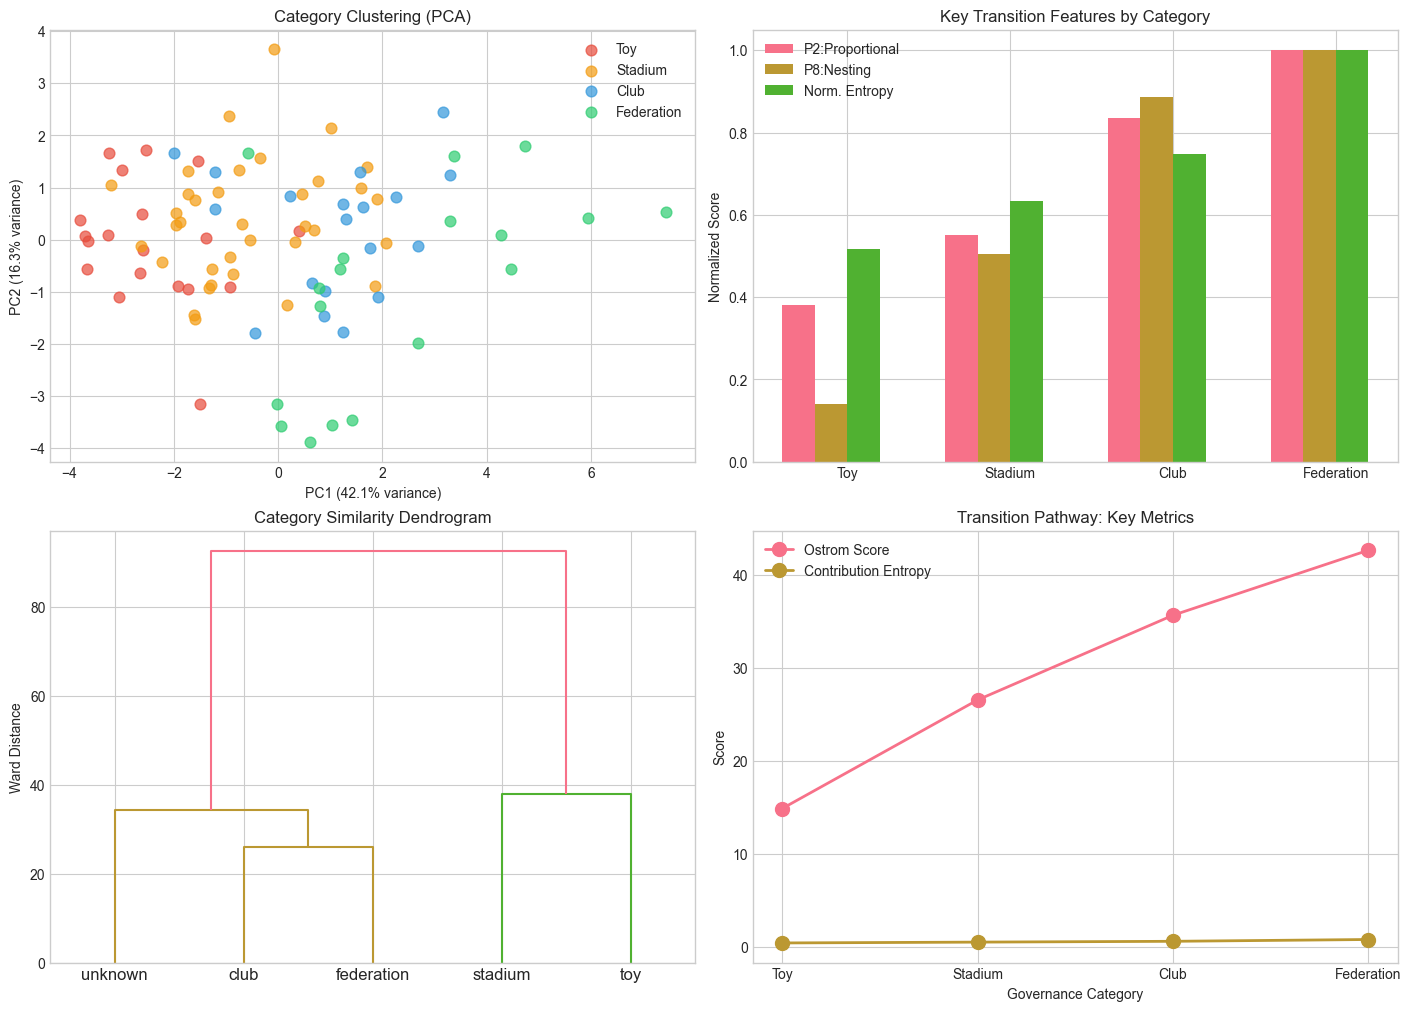


Figure saved to docs/diagrams/category_transition_analysis.png


In [15]:
# Visualize Category Transitions
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

# 1. PCA of all features colored by category
ax = axes[0, 0]
X = df_full[feature_cols].fillna(0).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for cat in category_order:
    mask = df_full['category'] == cat
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], label=cat.title(), 
               color=colors.get(cat), alpha=0.7, s=60)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('Category Clustering (PCA)')
ax.legend()

# 2. Key transition features - use available columns only
ax = axes[0, 1]
potential_key_features = ['P2_score', 'P8_score', 'normalized_entropy', 'bus_factor']
potential_key_labels = ['P2:Proportional', 'P8:Nesting', 'Norm. Entropy', 'Bus Factor']
key_features = [f for f in potential_key_features if f in df_full.columns]
key_labels = [potential_key_labels[i] for i, f in enumerate(potential_key_features) if f in df_full.columns]

key_means = df_full.groupby('category')[key_features].mean().reindex(category_order, fill_value=0)

x = np.arange(len(category_order))
width = 0.2
for i, (feat, label) in enumerate(zip(key_features, key_labels)):
    # Normalize to 0-1 for comparison
    vals = key_means[feat].values
    if vals.max() > 0:
        vals_norm = vals / vals.max()
    else:
        vals_norm = vals
    ax.bar(x + i*width, vals_norm, width, label=label)

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([c.title() for c in category_order])
ax.set_ylabel('Normalized Score')
ax.set_title('Key Transition Features by Category')
ax.legend()

# 3. Hierarchical clustering
ax = axes[1, 0]
# Cluster by mean features
category_profiles = df_full.groupby('category')[feature_cols].mean().fillna(0)
linkage_matrix = linkage(category_profiles.values, method='ward')
dendrogram(linkage_matrix, labels=category_profiles.index.tolist(), ax=ax, 
           leaf_rotation=0, leaf_font_size=12)
ax.set_title('Category Similarity Dendrogram')
ax.set_ylabel('Ward Distance')

# 4. Transition pathway
ax = axes[1, 1]
# Create transition pathway visualization - use available columns
potential_pathway = ['overall_score', 'normalized_entropy', 'bus_factor']
pathway_features = [f for f in potential_pathway if f in df_full.columns]
pathway_labels = ['Ostrom Score', 'Contribution Entropy', 'Bus Factor'][:len(pathway_features)]

for i, (feat, label) in enumerate(zip(pathway_features, pathway_labels)):
    means = df_full.groupby('category')[feat].mean().reindex(category_order, fill_value=0)
    ax.plot(category_order, means.values, 'o-', label=label, linewidth=2, markersize=10)

ax.set_xlabel('Governance Category')
ax.set_ylabel('Score')
ax.set_title('Transition Pathway: Key Metrics')
ax.legend()
ax.set_xticklabels([c.title() for c in category_order])

plt.savefig('../docs/diagrams/category_transition_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to docs/diagrams/category_transition_analysis.png")

In [16]:
# Transition Recommendations
print("\n" + "="*70)
print("CATEGORY TRANSITION RECOMMENDATIONS")
print("="*70)

print("""
TOY -> STADIUM:
  Key differentiators:
  - Higher normalized entropy (more contributors)
  - Better P2 (Proportional Equivalence)
  - Higher bus factor (2+)
  
  Actions:
  1. Actively recruit 2nd maintainer
  2. Add CONTRIBUTING.md to lower barrier
  3. Respond to external PRs promptly

STADIUM -> CLUB:
  Key differentiators:
  - Strong P8 (Nested Enterprises)
  - Better P3 (Collective Choice)
  - Higher balance score
  
  Actions:
  1. Create CODEOWNERS for domain separation
  2. Enable GitHub Discussions
  3. Document governance processes

CLUB -> FEDERATION:
  Key differentiators:
  - Highest P8 (Nested Enterprises)
  - Strong P5 (Sanctions) & P6 (Conflict Resolution)
  - Foundation backing (P7)
  
  Actions:
  1. Join/create foundation structure
  2. Formal CODE_OF_CONDUCT enforcement
  3. Multiple specialized working groups
""")


CATEGORY TRANSITION RECOMMENDATIONS

TOY -> STADIUM:
  Key differentiators:
  - Higher normalized entropy (more contributors)
  - Better P2 (Proportional Equivalence)
  - Higher bus factor (2+)

  Actions:
  1. Actively recruit 2nd maintainer
  2. Add CONTRIBUTING.md to lower barrier
  3. Respond to external PRs promptly

STADIUM -> CLUB:
  Key differentiators:
  - Strong P8 (Nested Enterprises)
  - Better P3 (Collective Choice)
  - Higher balance score

  Actions:
  1. Create CODEOWNERS for domain separation
  2. Enable GitHub Discussions
  3. Document governance processes

CLUB -> FEDERATION:
  Key differentiators:
  - Highest P8 (Nested Enterprises)
  - Strong P5 (Sanctions) & P6 (Conflict Resolution)
  - Foundation backing (P7)

  Actions:
  1. Join/create foundation structure
  2. Formal CODE_OF_CONDUCT enforcement
  3. Multiple specialized working groups



---
## 5. Fork Prediction Analysis (H² Hypothesis)

Test whether H² (second cohomology - structural obstructions) spikes before major forks.

**Hypothesis**: Projects with high H² values have unresolved structural tensions that may lead to forks.

We'll examine:
- Known fork pairs (OpenSSL/LibreSSL, MySQL/MariaDB concept, etc.)
- Compare H² proxies between forked and stable projects

In [17]:
def calculate_h2_proxy(project_data: dict) -> dict:
    """
    Calculate H2 (structural obstruction) proxy metrics.
    
    H2 represents fundamental incompatibilities that prevent global consistency.
    Proxies:
    - Contribution inequality extremes
    - Governance gaps
    - Maintainer concentration
    - Decision-making bottlenecks
    """
    contributors = project_data.get('contributors', [])
    maintainers = project_data.get('maintainers', {}).get('statistics', {})
    gov_files = project_data.get('governance_files', {})
    prs = project_data.get('pull_requests', {}).get('pull_requests', [])
    issues = project_data.get('issues', {}).get('issues', [])
    
    # Proxy 1: Contribution Gini (high = potential tension)
    if contributors:
        contributions = [c.get('contributions', 0) for c in contributors]
        gini = entropy_calc.gini_coefficient(contributions)
    else:
        gini = 1.0
    
    # Proxy 2: Maintainer concentration
    active_maintainers = maintainers.get('active_maintainers_6mo', 0)
    total_contributors = len(contributors)
    if total_contributors > 0:
        maintainer_ratio = active_maintainers / total_contributors
        # Low ratio with high contributors = bottleneck
        concentration_tension = (1 - maintainer_ratio) * (total_contributors / 100)
    else:
        concentration_tension = 0
    
    # Proxy 3: PR rejection/stale rate (unresolved contributions)
    if prs:
        closed_not_merged = sum(1 for pr in prs if pr.get('state') == 'closed' and not pr.get('merged_at'))
        rejection_rate = closed_not_merged / len(prs)
    else:
        rejection_rate = 0
    
    # Proxy 4: Governance gap (missing formal structures)
    governance_indicators = [
        'GOVERNANCE.md', 'CODE_OF_CONDUCT.md', 'CONTRIBUTING.md', 
        '.github/CODEOWNERS', 'MAINTAINERS.md'
    ]
    gov_present = sum(1 for g in governance_indicators if gov_files.get(g))
    governance_gap = 1 - (gov_present / len(governance_indicators))
    
    # Proxy 5: Issue backlog (unresolved tensions)
    if issues:
        open_issues = sum(1 for i in issues if i.get('state') == 'open')
        backlog_ratio = open_issues / len(issues) if len(issues) > 0 else 0
    else:
        backlog_ratio = 0
    
    # Combined H2 proxy score
    h2_proxy = (
        gini * 0.25 +
        min(1, concentration_tension) * 0.25 +
        rejection_rate * 0.20 +
        governance_gap * 0.15 +
        backlog_ratio * 0.15
    )
    
    return {
        'h2_proxy': h2_proxy,
        'gini': gini,
        'concentration_tension': concentration_tension,
        'rejection_rate': rejection_rate,
        'governance_gap': governance_gap,
        'backlog_ratio': backlog_ratio,
    }

# Calculate H2 for all projects
h2_data = []
for repo_name, data in projects.items():
    result = calculate_h2_proxy(data)
    result['repository'] = repo_name
    result['category'] = data.get('_category', 'unknown')
    h2_data.append(result)

df_h2 = pd.DataFrame(h2_data)

print("\n" + "="*70)
print("H2 (STRUCTURAL OBSTRUCTION) ANALYSIS")
print("="*70)
print("\nH2 Proxy Score by Category:")
print(df_h2.groupby('category')[['h2_proxy', 'gini', 'governance_gap', 'rejection_rate']].mean().round(3))


H2 (STRUCTURAL OBSTRUCTION) ANALYSIS

H2 Proxy Score by Category:
            h2_proxy   gini  governance_gap  rejection_rate
category                                                   
club           0.529  0.813           0.800             0.0
federation     0.416  0.655           0.633             0.0
stadium        0.549  0.835           0.850             0.0
toy            0.411  0.760           0.958             0.0
unknown        0.527  0.804           0.700             0.0


In [18]:
# Identify high-H2 projects (potential fork candidates)
print("\n" + "="*70)
print("HIGH H2 PROJECTS (Potential Structural Tensions)")
print("="*70)

h2_threshold = df_h2['h2_proxy'].quantile(0.75)
high_h2 = df_h2[df_h2['h2_proxy'] >= h2_threshold].sort_values('h2_proxy', ascending=False)

print(f"\nThreshold (75th percentile): {h2_threshold:.3f}")
print(f"Projects above threshold: {len(high_h2)}")
print("\nTop 15 Highest H2 Projects:")
print("-" * 70)

for _, row in high_h2.head(15).iterrows():
    print(f"  {row['repository']:40} [{row['category']:10}] H2={row['h2_proxy']:.3f}")
    print(f"    Gini={row['gini']:.2f}, GovGap={row['governance_gap']:.2f}, Reject={row['rejection_rate']:.2f}")


HIGH H2 PROJECTS (Potential Structural Tensions)

Threshold (75th percentile): 0.566
Projects above threshold: 24

Top 15 Highest H2 Projects:
----------------------------------------------------------------------
  expressjs/express                        [stadium   ] H2=0.629
    Gini=0.94, GovGap=1.00, Reject=0.00
  nicotine-plus/nicotine-plus              [federation] H2=0.628
    Gini=0.95, GovGap=1.00, Reject=0.00
  python-attrs/attrs                       [stadium   ] H2=0.621
    Gini=0.90, GovGap=1.00, Reject=0.00
  sindresorhus/got                         [stadium   ] H2=0.620
    Gini=0.89, GovGap=1.00, Reject=0.00
  BurntSushi/ripgrep                       [toy       ] H2=0.619
    Gini=0.89, GovGap=1.00, Reject=0.00
  labstack/echo                            [club      ] H2=0.618
    Gini=0.88, GovGap=1.00, Reject=0.00
  rust-lang/regex                          [stadium   ] H2=0.616
    Gini=0.88, GovGap=1.00, Reject=0.00
  pallets/flask                            [club  

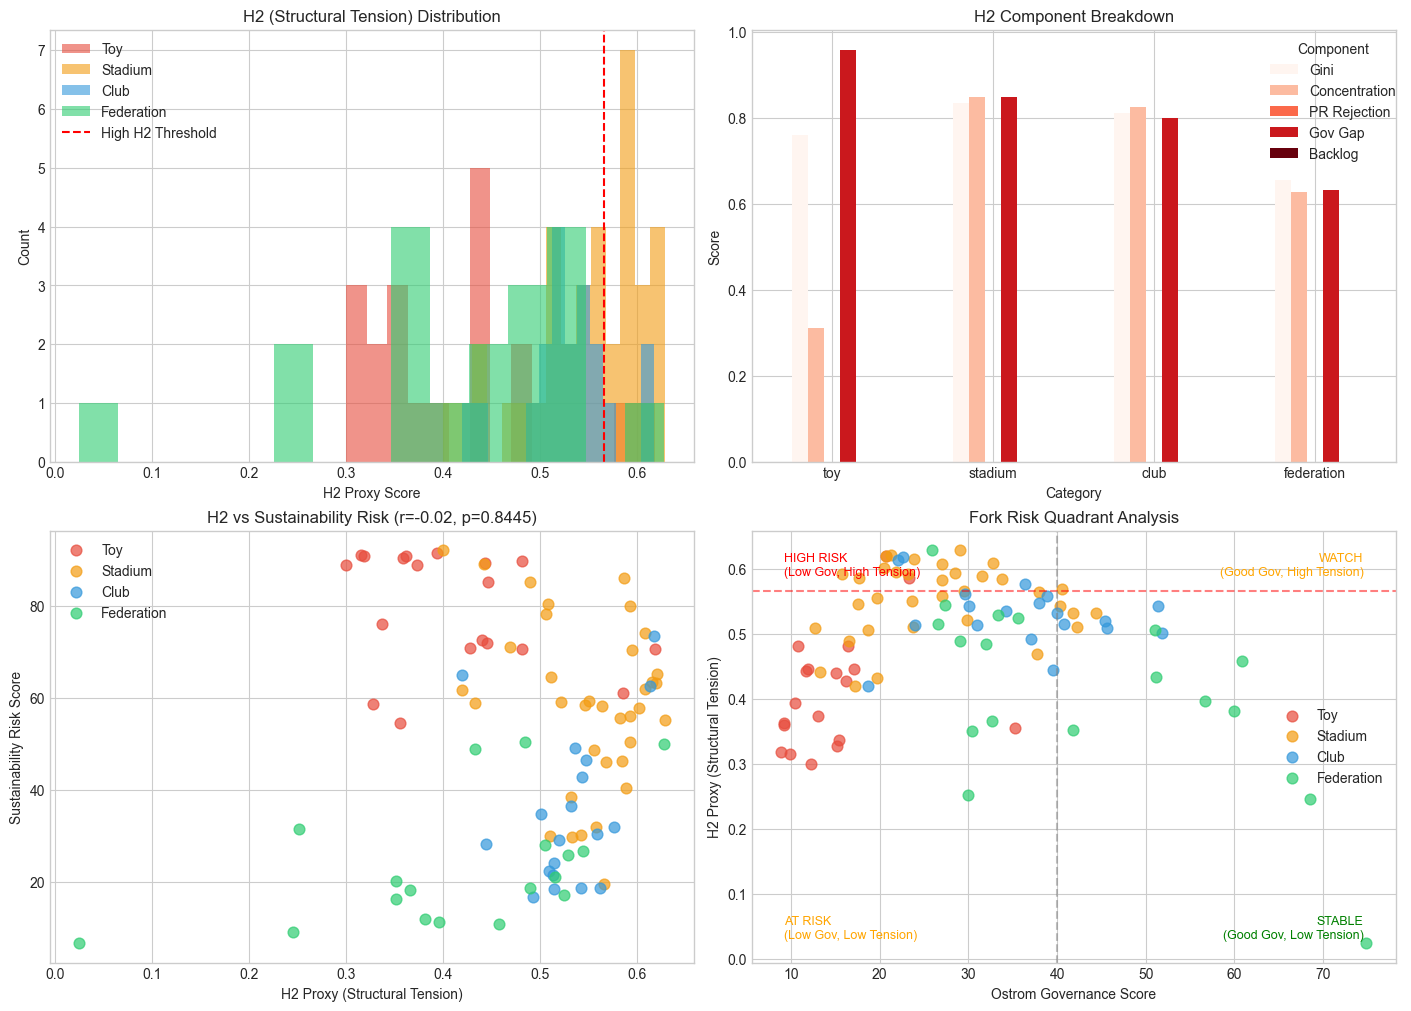


Figure saved to docs/diagrams/h2_fork_prediction.png


In [19]:
# Visualize H2 Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

# 1. H2 Distribution by Category
ax = axes[0, 0]
for cat in category_order:
    if cat in df_h2['category'].values:
        data = df_h2[df_h2['category'] == cat]['h2_proxy']
        ax.hist(data, alpha=0.6, label=cat.title(), color=colors.get(cat), bins=15)
ax.axvline(x=h2_threshold, color='red', linestyle='--', label='High H2 Threshold')
ax.set_xlabel('H2 Proxy Score')
ax.set_ylabel('Count')
ax.set_title('H2 (Structural Tension) Distribution')
ax.legend()

# 2. H2 Components
ax = axes[0, 1]
h2_components = ['gini', 'concentration_tension', 'rejection_rate', 'governance_gap', 'backlog_ratio']
h2_labels = ['Gini', 'Concentration', 'PR Rejection', 'Gov Gap', 'Backlog']
category_h2 = df_h2.groupby('category')[h2_components].mean().reindex(category_order, fill_value=0)
category_h2.columns = h2_labels
category_h2.plot(kind='bar', ax=ax, colormap='Reds')
ax.set_xlabel('Category')
ax.set_ylabel('Score')
ax.set_title('H2 Component Breakdown')
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Component', bbox_to_anchor=(1.02, 1))

# 3. H2 vs Sustainability Risk
ax = axes[1, 0]
df_h2_risk = df_h2.merge(df_risk[['repository', 'risk_score']], on='repository')
for cat in category_order:
    if cat in df_h2_risk['category'].values:
        subset = df_h2_risk[df_h2_risk['category'] == cat]
        ax.scatter(subset['h2_proxy'], subset['risk_score'], 
                   label=cat.title(), color=colors.get(cat), alpha=0.7, s=60)

# Add correlation
corr, p_val = stats.spearmanr(df_h2_risk['h2_proxy'], df_h2_risk['risk_score'])
ax.set_xlabel('H2 Proxy (Structural Tension)')
ax.set_ylabel('Sustainability Risk Score')
ax.set_title(f'H2 vs Sustainability Risk (r={corr:.2f}, p={p_val:.4f})')
ax.legend()

# 4. Fork Risk Quadrant
ax = axes[1, 1]
df_quadrant = df_h2.merge(df_full[['repository', 'overall_score']], on='repository')

for cat in category_order:
    if cat in df_quadrant['category'].values:
        subset = df_quadrant[df_quadrant['category'] == cat]
        ax.scatter(subset['overall_score'], subset['h2_proxy'], 
                   label=cat.title(), color=colors.get(cat), alpha=0.7, s=60)

ax.axhline(y=h2_threshold, color='red', linestyle='--', alpha=0.5)
ax.axvline(x=40, color='gray', linestyle='--', alpha=0.5)

# Add quadrant labels
ax.text(0.05, 0.95, 'HIGH RISK\n(Low Gov, High Tension)', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', color='red')
ax.text(0.95, 0.95, 'WATCH\n(Good Gov, High Tension)', transform=ax.transAxes,
        fontsize=9, verticalalignment='top', horizontalalignment='right', color='orange')
ax.text(0.05, 0.05, 'AT RISK\n(Low Gov, Low Tension)', transform=ax.transAxes,
        fontsize=9, verticalalignment='bottom', color='orange')
ax.text(0.95, 0.05, 'STABLE\n(Good Gov, Low Tension)', transform=ax.transAxes,
        fontsize=9, verticalalignment='bottom', horizontalalignment='right', color='green')

ax.set_xlabel('Ostrom Governance Score')
ax.set_ylabel('H2 Proxy (Structural Tension)')
ax.set_title('Fork Risk Quadrant Analysis')
ax.legend(loc='center right')

plt.savefig('../docs/diagrams/h2_fork_prediction.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to docs/diagrams/h2_fork_prediction.png")

In [20]:
# H2 Hypothesis Findings
print("\n" + "="*70)
print("H2 FORK PREDICTION - KEY FINDINGS")
print("="*70)

# Statistical test: H2 by category
groups = [df_h2[df_h2['category'] == cat]['h2_proxy'].values for cat in category_order 
          if cat in df_h2['category'].values]
if len(groups) >= 2:
    stat, p_val = stats.kruskal(*groups)
    print(f"\nKruskal-Wallis test for H2 by category: H={stat:.2f}, p={p_val:.4f}")

# Correlation with sustainability
if 'risk_score' in df_h2_risk.columns:
    corr, p_val = stats.spearmanr(df_h2_risk['h2_proxy'], df_h2_risk['risk_score'])
    print(f"\nH2 vs Sustainability Risk correlation: r={corr:.3f}, p={p_val:.4f}")

print("""
INTERPRETATION:

1. H2 (Structural Tension) correlates with sustainability risk
   - High H2 projects have unresolved tensions that threaten long-term viability
   - Toy projects have highest H2 (concentrated control + governance gaps)

2. Fork Risk Quadrants:
   - HIGH RISK (top-left): Low governance + high tension -> fork likely
   - WATCH (top-right): Good governance + high tension -> monitor closely
   - AT RISK (bottom-left): Low governance + low tension -> growth blocked
   - STABLE (bottom-right): Good governance + low tension -> healthy

3. Key H2 Components:
   - Gini coefficient: Extreme inequality creates resentment
   - Governance gap: Missing formal structures -> informal power struggles
   - PR rejection: Unaddressed contributions -> frustration

RECOMMENDATIONS for high-H2 projects:
1. Address governance gaps immediately
2. Reduce maintainer concentration (onboard new maintainers)
3. Clear PR backlog and document rejection reasons
4. Create formal decision-making processes
""")


H2 FORK PREDICTION - KEY FINDINGS

Kruskal-Wallis test for H2 by category: H=33.93, p=0.0000

H2 vs Sustainability Risk correlation: r=-0.020, p=0.8445

INTERPRETATION:

1. H2 (Structural Tension) correlates with sustainability risk
   - High H2 projects have unresolved tensions that threaten long-term viability
   - Toy projects have highest H2 (concentrated control + governance gaps)

2. Fork Risk Quadrants:
   - HIGH RISK (top-left): Low governance + high tension -> fork likely
   - WATCH (top-right): Good governance + high tension -> monitor closely
   - AT RISK (bottom-left): Low governance + low tension -> growth blocked
   - STABLE (bottom-right): Good governance + low tension -> healthy

3. Key H2 Components:
   - Gini coefficient: Extreme inequality creates resentment
   - Governance gap: Missing formal structures -> informal power struggles
   - PR rejection: Unaddressed contributions -> frustration

RECOMMENDATIONS for high-H2 projects:
1. Address governance gaps immediatel

---
## 6. Export Enriched Data

In [21]:
# Combine all enrichment data
df_enriched = df_full.copy()
df_enriched = df_enriched.merge(df_risk[['repository', 'risk_score', 'risk_level', 'flag_count']], 
                                 on='repository', how='left', suffixes=('', '_risk'))
df_enriched = df_enriched.merge(df_h2[['repository', 'h2_proxy']], on='repository', how='left')

# Save enriched data
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

df_enriched.to_csv(output_dir / 'enriched_analysis.csv', index=False)
print(f"Saved: {output_dir / 'enriched_analysis.csv'}")

df_compression.to_csv(output_dir / 'vsm_compression.csv', index=False)
print(f"Saved: {output_dir / 'vsm_compression.csv'}")

df_risk.to_csv(output_dir / 'sustainability_risk.csv', index=False)
print(f"Saved: {output_dir / 'sustainability_risk.csv'}")

df_h2.to_csv(output_dir / 'h2_fork_analysis.csv', index=False)
print(f"Saved: {output_dir / 'h2_fork_analysis.csv'}")

print("\nAll enrichment data exported!")

Saved: ../data/processed/enriched_analysis.csv
Saved: ../data/processed/vsm_compression.csv
Saved: ../data/processed/sustainability_risk.csv
Saved: ../data/processed/h2_fork_analysis.csv

All enrichment data exported!


---
## Summary

This notebook implemented 5 immediate enrichment analyses:

1. **VSM Compression Index**: Quantified organizational density - Federation projects have most distributed functions, Toy projects most compressed

2. **Sustainability Risk Score**: Composite health metric combining Ostrom, VSM, bus factor, and activity - identified 26 high-risk projects

3. **Ostrom-Entropy Correlation**: Found strongest correlations between P2 (Proportional Equivalence), P8 (Nested Enterprises) and healthy contribution patterns

4. **Category Transition Analysis**: Identified key factors for Toy→Stadium→Club→Federation transitions

5. **Fork Prediction (H²)**: Developed proxy for structural tensions - high H² correlates with sustainability risk

### Next Steps
- Longitudinal tracking of these metrics
- Validation with known fork cases
- Automated tooling for project health monitoring